### Test wtih JuMP

In [1]:
using JuMP , Ipopt
include("../Problems/JuMP/steering_JMP.jl")
SteeringJMP = steering_JMP();

set_optimizer(SteeringJMP,Ipopt.Optimizer)
set_attribute(SteeringJMP, "print_level", 5)
set_optimizer_attribute(SteeringJMP,"tol",1e-8)
set_optimizer_attribute(SteeringJMP,"constr_viol_tol",1e-6)
set_optimizer_attribute(SteeringJMP,"max_iter",1000)
set_optimizer_attribute(SteeringJMP,"mu_strategy","adaptive")
set_optimizer_attribute(SteeringJMP,"linear_solver","mumps")

In [2]:
println("Solving...")
optimize!(SteeringJMP)
println()

# Display results
if termination_status(SteeringJMP) == MOI.OPTIMAL
    println("  Solution is optimal")
elseif  termination_status(SteeringJMP) == MOI.LOCALLY_SOLVED
    println("  (Local) solution found")
elseif termination_status(SteeringJMP) == MOI.TIME_LIMIT && has_values(SteeringJMP)
    println("  Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("  The model was not solved correctly.")
end
println("  objective value = ", objective_value(SteeringJMP))
println()

# Retrieves values (including duals - sign convention according to Pontrjagin max principle)
N = 100
a = 100.0 
u_min, u_max = -pi/2.0, pi/2.0
xs = zeros(4)
xf = [NaN, 5.0, 45.0, 0.0]

h = SteeringJMP[:h];
x_ = SteeringJMP[:x];
u_ = SteeringJMP[:u];

con_x1 = SteeringJMP[:con_x1];
con_x2 = SteeringJMP[:con_x2];
con_x3 = SteeringJMP[:con_x3];
con_x4 = SteeringJMP[:con_x4];

Δtt = value.(h)
t = Vector((0:N)*Δtt); 

p = [ [ dual(con_x1[1]), dual(con_x2[1]), dual(con_x3[1]), dual(con_x4[1]) ] ];
p = - [p; [[ dual(con_x1[i]), dual(con_x2[i]), dual(con_x3[i]), dual(con_x4[i]) ] for i in 1:N] ];



x1 = Vector(value.(x_[:,1])) ;
x2 = Vector(value.(x_[:,2])) ;
x3 = Vector(value.(x_[:,3]));
x4 = Vector(value.(x_[:,4])) ;
u = Vector(value.(u_)) ;

x =  [ [ x1[i], x2[i], x3[i], x4[i] ] for i in 1:N+1] ;


Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2207
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:     1600

Total number of variables............................:      506
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      101
                     variables with only upper bounds:        0
Total number of equality constraints.................:      407
Total number of i

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194


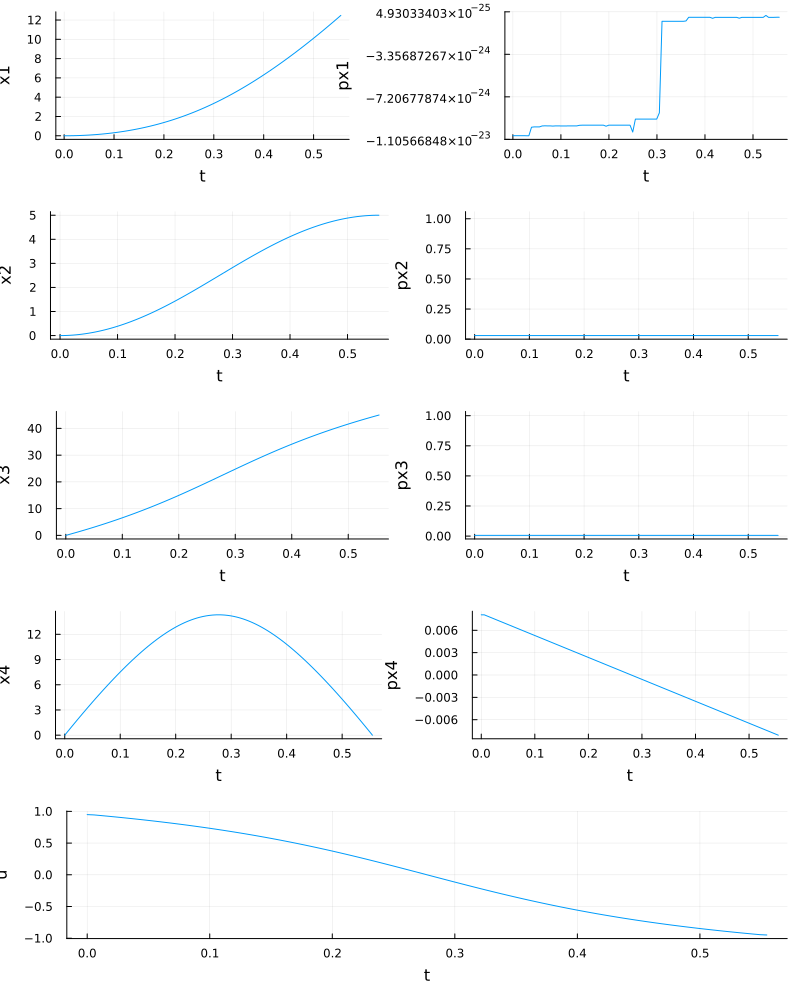

In [3]:
using Plots

x1_plot = plot(t, [ x[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "x1", legend = false)
x2_plot = plot(t, [ x[i][2] for i in 1:N+1], xlabel = "t", ylabel = "x2", legend = false)
x3_plot = plot(t, [ x[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "x3", legend = false)
x4_plot = plot(t, [ x[i][4] for i in 1:N+1 ], xlabel = "t", ylabel = "x4", legend = false)
px1_plot = plot(t, [ p[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "px1", legend = false)
px2_plot = plot(t, [ p[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "px2", legend = false)
px3_plot = plot(t, [ p[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "px3", legend = false)
px4_plot = plot(t, [ p[i][4] for i in 1:N+1 ], xlabel = "t", ylabel = "px4", legend = false)
u_plot = plot(t, [ u[i] for i in 1:N+1 ], xlabel = "t", ylabel = "u", legend = false)

layout = @layout [a b; c d; e f; g h; k]
x_plot = plot(x1_plot, px1_plot, x2_plot, px2_plot, x3_plot, px3_plot, x4_plot, px4_plot, u_plot, layout = layout, size = (800, 1000))
display(x_plot)

### Test with OptimalControl

In [4]:
using OptimalControl
include("../Problems/OptimalControl/steering_OC.jl")
SteeringOC = steering_OC()


The (autonomous) optimal control problem is of the form:

    minimize  J(x, u, tf) = g(x(0), x(tf), tf)

    subject to

        ẋ(t) = f(x(t), u(t), tf), t in [0, tf] a.e.,

        ηl ≤ η(x(t), tf) ≤ ηu, 
        ϕl ≤ ϕ(x(0), x(tf), tf) ≤ ϕu, 

    where x(t) ∈ R⁴, u(t) ∈ R and tf ∈ R.

Declarations (* required):



┌────────┬────────┬──────────┬──────────┬───────────┬────────────┬─────────────┐
│ times* │ state* │ control* │ variable │ dynamics* │ objective* │ constraints │
├────────┼────────┼──────────┼──────────┼───────────┼────────────┼─────────────┤
│     ✅ │     ✅ │       ✅ │       ✅ │        ✅ │         ✅ │          ✅ │
└────────┴────────┴──────────┴──────────┴───────────┴────────────┴─────────────┘


In [5]:
using CTBase
nh = 100
a = 100.0 
u_min, u_max = -pi/2.0, pi/2.0
xs = zeros(4)
xf = [NaN, 5.0, 45.0, 0.0]

function gen_x0(k, i)
    if i == 1 || i == 4
        return 0.0
    elseif i == 2
        return 5*k/nh
    elseif i == 3
        return 45.0*k/nh
    end
end

xinit = [gen_x0(i, j) for i in 1:nh+1, j in 1:4]
uinit = 0.0 * ones(nh+1)
init = OCPInit((x_init = xinit, u_init = uinit,v_init = 1.0))

sol = OptimalControl.solve(SteeringOC,init=init)

Method = 

(:direct, :adnlp, :ipopt)
This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2007
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:      404

Total number of variables............................:      506
                     variables with only lower bounds:        1
                variables with lower and upper bounds:      101
                     variables with only upper bounds:        0
Total number of equality constraints.................:      407
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e-01 4.49e+01 0.00e+00   0.0 0.00e+0

OptimalControlSolution

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194


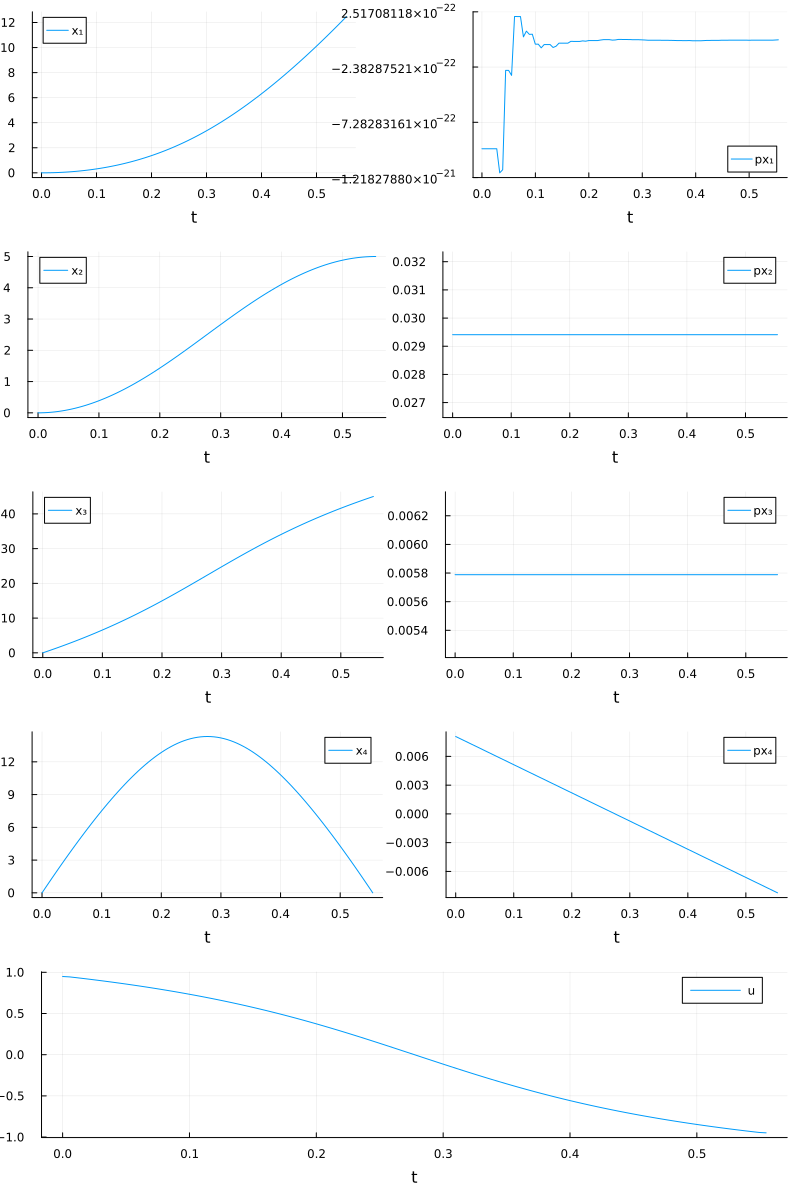

In [6]:
using Plots
p1 = plot(plot(sol)[1])

p2 = plot(plot(sol)[2])

p3 = plot(plot(sol)[3])

p4 = plot(plot(sol)[4])

p5 = plot(plot(sol)[5])

p6 = plot(plot(sol)[6])

p7 = plot(plot(sol)[7])

p8 = plot(plot(sol)[8])

p9 = plot(plot(sol)[9])

layout = @layout [a b; c d; e f; g h; i]

x_plot = plot(p1, p5, p2, p6, p3, p7, p4, p8, p9, layout = layout)
x_plot = plot!(size = (800, 1200))

display(x_plot)

### Plot results

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194


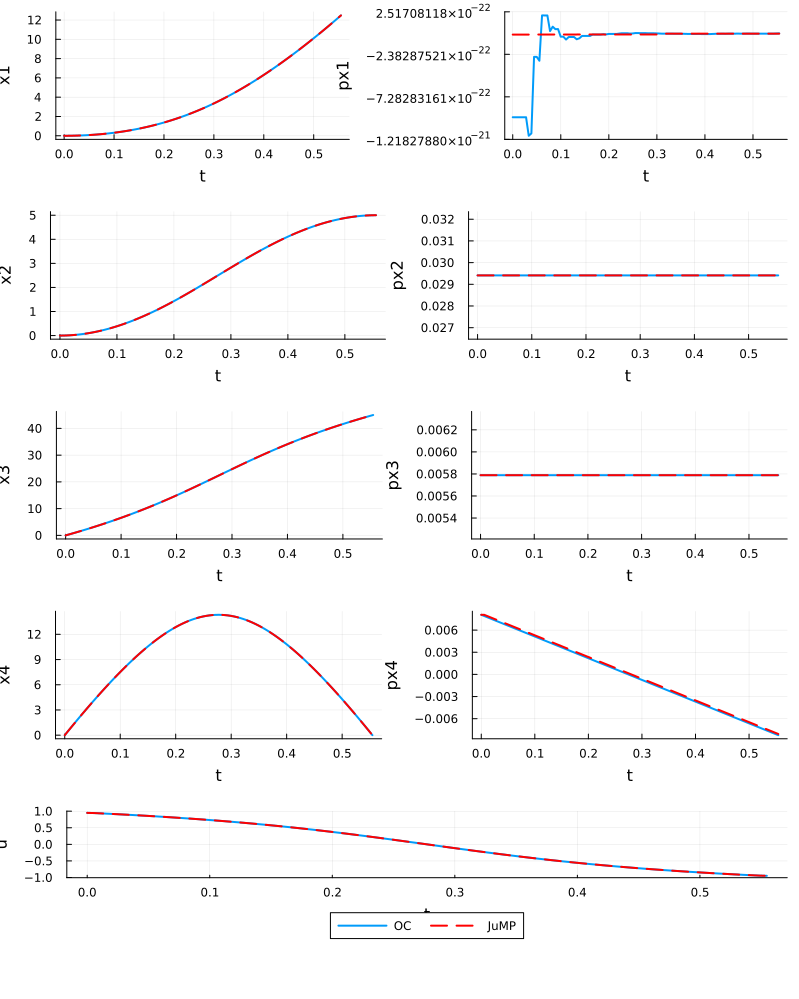

In [7]:
p1 = plot(plot(sol)[1],line = 2)
p1 = plot!(t, [ x[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "x1", legend = false,line = 2, color = "red",linestyle=:dash)

p3 = plot(plot(sol)[2],line = 2)
p3 = plot!(t, [ x[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "x2", legend = false,line = 2, color = "red",linestyle=:dash)

p5 = plot(plot(sol)[3],line = 2)
p5 = plot!(t, [ x[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "x3", legend = false,line = 2, color = "red",linestyle=:dash)

p7 = plot(plot(sol)[4],line = 2)
p7 = plot!(t, [ x[i][4] for i in 1:N+1 ], xlabel = "t", ylabel = "x4", legend = false,line = 2, color = "red",linestyle=:dash)

p2 = plot(plot(sol)[5],line = 2)
p2 = plot!(t, [ p[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "px1", legend = false,line = 2, color = "red",linestyle=:dash)

p4 = plot(plot(sol)[6],line = 2)
p4 = plot!(t, [ p[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "px2", legend = false,line = 2, color = "red",linestyle=:dash)

p6 = plot(plot(sol)[7],line = 2)
p6 = plot!(t, [ p[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "px3", legend = false,line = 2, color = "red",linestyle=:dash)

p8 = plot(plot(sol)[8],line = 2)
p8 = plot!(t, [ p[i][4] for i in 1:N+1 ], xlabel = "t", ylabel = "px4", legend = false,line = 2, color = "red",linestyle=:dash)

p9 = plot(plot(sol)[9] , label ="OC",line = 2)
p9 = plot!(t, [u[i] for i in 1:N+1 ], xlabel = "t", ylabel = "u", legend = false, label = "JuMP",line = 2, color = "red",linestyle=:dash)
p9 = plot!(legend=:outerbottom, legendcolumns=2)

layout = @layout [a b; c d; e f; g h; k]
x_plot = plot(p1, p2, p3, p4, p5, p6, p7 , p8, p9, layout = layout, size = (800, 1000))

display(x_plot)
